<a href="https://colab.research.google.com/github/sahithijarugula/Recognize_Cloud_Coverage/blob/main/Final_Thresholding_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FIRE199 FINAL Thresholding Work**
##Hybrid Method & Confusion Matrix

###Sahithi Jarugula

###Last Updated: July 20, 2022

# Imports

In [ ]:
#Arrays & matrices
import numpy as np
#Dataframes
import pandas as pd
#Image plotting
import matplotlib.pyplot as plt
#Confusion Matrix Creation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Image reading & thresholding
import cv2
#Image processing & manipulation
from PIL import Image
#Mounting to google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


# Methods

###Thresholding Methods

In [ ]:
def blue_channel(image):
  #Extracts blue channel of image
  blue_channel = image[:, :, 2]
  blue_image = np.zeros(image.shape)
  blue_image[:, :, 0] = blue_channel
  #Saturates the blue channel
  hsv_image = cv2.cvtColor(blue_image.astype(np.uint8), cv2.COLOR_BGR2HSV)
  invert_hsv = cv2.bitwise_not(hsv_image)
  #Converts to gray scale
  gray = cv2.cvtColor(invert_hsv, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5,5), 0)
  #Finds threshold using adaptive thresholding
  adaptive = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 101, 5)

  return adaptive
#Conclusion: Does not work well in general, but works well on none/mostly clear data

def clahe_thresholding(image, thresholds):
  #Saturates image by getting its hsv version
  hsv_image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2HSV)
  #Inverts hsv
  inverted_hsv = cv2.bitwise_not(hsv_image)
  #Hsv to gray scale
  gray = cv2.cvtColor(inverted_hsv, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5,5), 0)
  #CLAHE - good for overcast images
  clahe = cv2.createCLAHE(clipLimit = 5)
  final_img = clahe.apply(blurred) + 30
  #Thresholding
  (T, thresh) = cv2.threshold(final_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  thresholds = np.append(thresholds, T)
  if(T < 80):
    thresh = None
  elif(T < 90):
    thresh = convert_thresh(image, 0)
  elif(T > 176):
    thresh = convert_thresh(image, 255)
  return thresh, thresholds

def saturation_thresholding(image, thresholds):
  #Convert to hsv (saturates image)
  hsv_image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2HSV)
  #Inverts hsv
  inverted_hsv = cv2.bitwise_not(hsv_image)
  #Gets gray scale of saturated image
  gray = cv2.cvtColor(inverted_hsv, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5,5), 0)
  #Thresholding
  (T, thresh) = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  thresholds = np.append(thresholds, T)
  if(T < 80):
    thresh = None
  elif(T < 90):
    thresh = convert_thresh(image, 0)
  elif(T > 176):
    thresh = convert_thresh(image, 255)
  return thresh, thresholds

###Auxiliary Methods

In [ ]:
#Reads a google drive image
def read_drive_image(file):
  image = cv2.imread(file)
  return image

#Converts a given threshold image to a single color
def convert_thresh(image, value):
  thresh = Image.fromarray(image)
  pixel_map = thresh.load()
  width, height = thresh.size
  for i in range(width):
    for j in range(height):
      pixel_map[i, j] = (value, value, value)
  thresh = cv2.cvtColor(np.array(thresh), cv2.COLOR_RGB2BGR)
  thresh = cv2.cvtColor(np.array(thresh), cv2.COLOR_BGR2GRAY)
  return thresh

#Classifies cloud coverage of a thresholded image
def classify(thresh):
  #Calculate percentage of clouds in sky
  if thresh is None:
    percentage = 5
  else:
    cloud_pixels = np.sum(thresh == 255)
    width, height = thresh.shape
    percentage = cloud_pixels/(width*height) * 100
  #Returns cloud category
  if percentage == 0:
    return "None"
  elif percentage < 10:
    return "Mostly Clear"
  elif percentage < 25:
    return "Isolated"
  elif percentage < 50:
    return "Scattered"
  elif percentage < 90:
    return "Broken"
  else:
    return "Overcast"

#Determines how many of the sample dataset images a given method classified correctly
def accuracy_rate(classifications):
  correct = 0
  for i in range(0, len(classifications)):
    if classifications[i] == categories[i]:
        correct = correct + 1
  return correct/len(classifications)


##Classification

###Sample Dataset

In [ ]:
#Sample Dataset from Google Drive
sheet_url = "https://docs.google.com/spreadsheets/d/1BmXDMmFj98ql52MJBORxWPPOWRkO8rdV5wRI-tfUGw4/edit#gid=0"
url_1 = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
sdf = pd.read_csv(url_1, error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


###Performance of Thresholding Methods

In [ ]:
#Classifying Data
thresholds_c = np.array([]) #CLAHE method thresholds
thresholds_s = np.array([]) #Saturation method thresholds

#Gets the correct classifications from the Google sheets data and converts to an array
categories = sdf['Category'].to_numpy()

#Arrays that will hold the classifications of the CLAHE & saturation methods
clahe_classifications = np.array([])
saturation_classifications = np.array([])
blue_classifications = np.array([])

#Classifying all images in dataset using blue channel, CLAHE, & saturation methods
for data in sdf['Images']:
  image = read_drive_image(data)
  #Using blue channel thresholding
  img_b = blue_channel(image)
  classification = classify(img_b)
  blue_classifications = np.append(blue_classifications, classification)
  #Using CLAHE thresholding
  img_c, thresholds_c = clahe_thresholding(image, thresholds_c)
  classification = classify(img_c)
  clahe_classifications = np.append(clahe_classifications, classification)
  #Using saturation thresholding
  img_s, thresholds_s = saturation_thresholding(image, thresholds_s)
  classification = classify(img_s)
  saturation_classifications = np.append(saturation_classifications, classification)

#Automatic Hybrid thresholding method
i = 0
hybrid_classifications = np.array([])
for data in sdf['Images']:
  #If images are overcast, use CLAHE classifications
  if thresholds_c[i] > 176:
    hybrid_classifications = np.append(hybrid_classifications, clahe_classifications[i])
  #If images are none or mostly clear run blue channel thresholding
  elif thresholds_s[i] < 95:
    hybrid_classifications = np.append(hybrid_classifications, blue_classifications[i])
  #Else use saturation classifications
  else:
    hybrid_classifications = np.append(hybrid_classifications, saturation_classifications[i])
  i = i + 1

#Accuracy rates of thresholding methods
blue_accuracy = accuracy_rate(blue_classifications)
print("Blue Channel: " + str(blue_accuracy)) #0.275

clahe_accuracy = accuracy_rate(clahe_classifications)
print("CLAHE: " + str(clahe_accuracy)) #0.38333333333333336

saturation_accuracy = accuracy_rate(saturation_classifications)
print("Saturation: " + str(saturation_accuracy)) #0.425

hybrid_accuracy = accuracy_rate(hybrid_classifications)
print("Hybrid: " + str(hybrid_accuracy)) #0.4



Blue Channel: 0.275
CLAHE: 0.38333333333333336
Saturation: 0.425
Hybrid: 0.4


##Confusion Matrices

In [ ]:
data = {
  "True Values": categories,
  "Blue Channel": blue_classifications,
  "CLAHE": clahe_classifications,
  "Saturation": saturation_classifications,
  "Hybrid": hybrid_classifications
}

df = pd.DataFrame(data)
values = df.replace({'None' : 0, 'Mostly Clear' : 1, 'Isolated' : 2, 'Scattered' : 3, 'Broken' : 4, 'Overcast' : 5})

'\ndef convert_array(arr):\n  arr2 = np.where(arr is "None", 0, arr)\n  arr2 = np.where(arr is \'Mostly Clear\', 1, arr)\n  arr2 = np.where(arr is \'Isolated\', 2, arr)\n  arr2 = np.where(arr is \'Scattered\', 3, arr)\n  arr2 = np.where(arr is \'Broken\', 4, arr)\n  arr2 = np.where(arr is \'Overcast\', 5, arr)\n  return arr2\n\n#categories = convert_array(categories)\nprint(actual_val)\n#blue_classifications = convert_array(blue_classifications)\nprint(blue_classifications)\n#clahe_classifications = convert_array(clahe_classifications)\n#saturation_classifications = convert_array(saturation_classifications)\n#hybrid_classifications = convert_array(hybrid_classifications)'

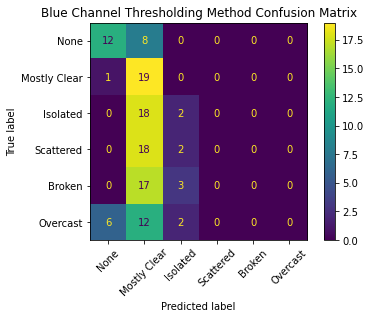

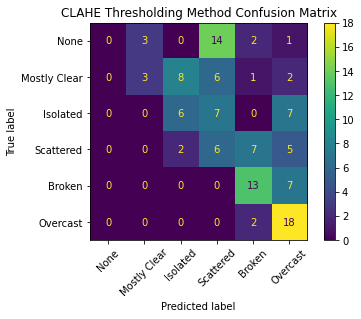

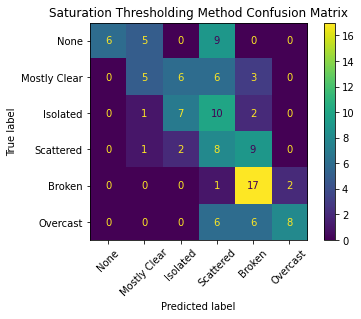

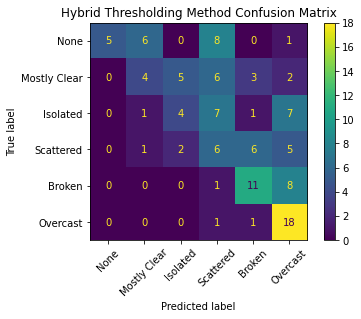

In [ ]:
#Confusion matrix for blue channel Thresholding method
blue_matrix = confusion_matrix(values['True Values'], values['Blue Channel'])
cs_matrix = ConfusionMatrixDisplay(confusion_matrix=blue_matrix, display_labels=['None', 'Mostly Clear', 'Isolated', 'Scattered', 'Broken', 'Overcast'])
cs_matrix.plot()
cs_matrix.ax_.set_title("Blue Channel Thresholding Method Confusion Matrix")
plt.xticks(rotation = 45)
plt.show()

#Confusion matrix for CLAHE Thresholding method
clahe_matrix = confusion_matrix(values['True Values'], values['CLAHE'])
cs_matrix = ConfusionMatrixDisplay(confusion_matrix=clahe_matrix, display_labels=['None', 'Mostly Clear', 'Isolated', 'Scattered', 'Broken', 'Overcast'])
cs_matrix.plot()
cs_matrix.ax_.set_title("CLAHE Thresholding Method Confusion Matrix")
plt.xticks(rotation = 45)
plt.show()

#Confusion matrix for saturation Thresholding method
saturation_matrix = confusion_matrix(values['True Values'], values['Saturation'])
cs_matrix = ConfusionMatrixDisplay(confusion_matrix=saturation_matrix, display_labels=['None', 'Mostly Clear', 'Isolated', 'Scattered', 'Broken', 'Overcast'])
cs_matrix.plot()
cs_matrix.ax_.set_title("Saturation Thresholding Method Confusion Matrix")
plt.xticks(rotation = 45)
plt.show()

#Confusion matrix for Hybrid Thresholding method
hybrid_matrix = confusion_matrix(values['True Values'], values['Hybrid'])
cs_matrix = ConfusionMatrixDisplay(confusion_matrix=hybrid_matrix, display_labels=['None', 'Mostly Clear', 'Isolated', 'Scattered', 'Broken', 'Overcast'])
cs_matrix.plot()
cs_matrix.ax_.set_title("Hybrid Thresholding Method Confusion Matrix")
plt.xticks(rotation = 45)
plt.show()